<h1>IMDb Reviews Sentiment Analysis</h1>
<h4>Author: Chang Dakota Sum Kiu</h4>
<h4>Last Modified: 17/11/2021</h4>


---


This notebook documents the training of a multinomial Naive Bayes Classfier that predicts the sentiment of moview reviews. The model is trained on an [IMDb dataset from kaggle](https://www.kaggle.com/ashirwadsangwan/imdb-dataset).


<h2>Importing libraries</h2>

In [1]:
# Libraries for cleaning/parsing Data
from bs4 import BeautifulSoup
import re,string,unicodedata

# PyData Stack
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sci-Kit Learn
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import spacy
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

<h2>Importing Data Set</h2>

In [2]:
imdb_df = pd.read_csv('/Users/dcoder/Desktop/school/csc630/SentimentAnalysis/IMDB Dataset.csv')
print(imdb_df.shape)
imdb_df.sample(3)

(50000, 2)


,review,sentiment
49402,Every movie Quentin Tarantino has made has bec...,negative
32453,This movie had such a good premise to start wi...,negative
41679,One is tempted to define the genre of Gert de ...,positive


<h2>Data exploration</h2>

In [3]:
print(imdb_df.describe())
print(imdb_df['sentiment'].value_counts())

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000
positive    25000
negative    25000
Name: sentiment, dtype: int64


#### In this example, we can see that there are html tags and noise to be cleaned, stop words to be removed, and words to go through the process of stemming

In [4]:
print(imdb_df['review'][0])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

<h2>Train Test Split</h2>

In [5]:
X_train = imdb_df.review[:40000]
y_train = imdb_df.sentiment[:40000]

X_test = imdb_df.review[40000:]
y_true = imdb_df.sentiment[40000:]

print(X_train.shape,y_train.shape)
print(X_test.shape,y_true.shape)

(40000,) (40000,)
(10000,) (10000,)


<h2>Text Normalization</h2>

In [6]:
# https://www.nltk.org/_modules/nltk/tokenize/toktok.html (source/documentation)
nltk.download('stopwords')
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dcoder/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Normalizing/Cleaning the data using regex and other methods
# Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing the noise
def denoise(text):
    text = strip_html(text)
    text = remove_square_brackets(text)
    return text

# Removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

# Stemming
def stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

# Removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [8]:
imdb_df['review'] = imdb_df['review'].apply(denoise)
imdb_df['review'] = imdb_df['review'].apply(remove_special_characters)
imdb_df['review'] = imdb_df['review'].apply(stemmer)

stop=set(stopwords.words('english'))
imdb_df['review']=imdb_df['review'].apply(remove_stopwords)

## Checking the normalized text

In [9]:
norm_X_train = imdb_df.review[:40000]
norm_X_test = imdb_df.review[40000:]
norm_X_test[40000]

'first want say lean liber polit scale found movi offens manag watch whole doggon disgrac film thi movi bring low origin idea ye wa origin thu 2 star instead 1 film writer uncr onli come thi act wa horribl charact unlik part lead ladi stori good qualiti made bf sort bad guy see mayb miss someth knowh wa earth relev charact movi shell ani money thi garbag almost wish peta would come rescu thi aw offens movi form protest disgust say anymor'

# Model Training

### Using the count vectorizer from SciKit Learn to transform the text into vectors based on the count/frequency of each word

In [10]:
# for bag of words
cv = CountVectorizer(min_df=0, max_df=1, binary=False, ngram_range=(1,3))
cv_X_train = cv.fit_transform(norm_X_train)
cv_X_test = cv.transform(norm_X_test)

print('BOW_cv_train: ',cv_X_train.shape)
print('BOW_cv_test: ',cv_X_test.shape)

BOW_cv_train:  (40000, 6209089)
BOW_cv_test:  (10000, 6209089)


### Using the TFIDF vectorized from SciKit Learn to transform text into feature vectors to be used as input to the estimator

In [11]:
tv = TfidfVectorizer(min_df=0, max_df=1, use_idf=True, ngram_range=(1,3))
tv_X_train = tv.fit_transform(norm_X_train)
tv_X_test = tv.transform(norm_X_test)
print('Tfidf_train: ',tv_X_train.shape)
print('Tfidf_test: ',tv_X_test.shape)

Tfidf_train:  (40000, 6209089)
Tfidf_test:  (10000, 6209089)


### One-hot encoding/Making multi-class labels binary

In [12]:
#labeling the sentiment data
lb = LabelBinarizer()
y = lb.fit_transform(imdb_df['sentiment'])
print(y.shape)

(50000, 1)


### Train test split

In [13]:
y_train = y[:40000]
y_test = y[40000:]

### Training the Logistic Regression model using the vectorized data

In [14]:
lm = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)
lm_bow = lm.fit(cv_X_train, y_train)
print(lm_bow)

lm_tfidf = lm.fit(tv_X_train, y_train)
print(lm_tfidf)

/Users/dcoder/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


/Users/dcoder/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


### Making predictions with bag of words and TFIDF

In [15]:
lm_bow_preds = lm.predict(cv_X_test)
lm_tfidf_preds = lm.predict(tv_X_test)

### Testing accuracy of bag of word and TFIDF

##### Accuracy score:

In [16]:
lm_bow_score = accuracy_score(y_test, lm_bow_preds)
print("lm_bow_score: ",lm_bow_score)

lm_tfidf_score = accuracy_score(y_test, lm_tfidf_preds)
print("lm_tfidf_score: ",lm_tfidf_score)

lm_bow_score:  0.7512
lm_tfidf_score:  0.75


##### Classification report:

In [17]:
lm_bow_report = classification_report(y_test, lm_bow_preds, target_names=['Positive','Negative'])
print(lm_bow_report)

lm_tfidf_report = classification_report(y_test, lm_tfidf_preds, target_names=['Positive','Negative'])
print(lm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.75      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



##### Confusion matrix:

In [18]:
cm_bow = confusion_matrix(y_test, lm_bow_preds, labels=[1,0])
print(cm_bow)

cm_tfidf = confusion_matrix(y_test, lm_tfidf_preds, labels=[1,0])
print(cm_tfidf)

[[3768 1239]
 [1249 3744]]
[[3663 1344]
 [1156 3837]]


### Training the Support Vector Machine to separate data into classes

In [19]:
svm = SGDClassifier(loss='hinge',max_iter=500,random_state=42)

svm_bow = svm.fit(cv_X_train, y_train)
print(svm_bow)

svm_tfidf = svm.fit(tv_X_train, y_train)
print(svm_tfidf)

/Users/dcoder/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)


/Users/dcoder/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)


### Making predictions with bag of words and TFIDF

In [20]:
svm_bow_preds = svm.predict(cv_X_test)
print(svm_bow_preds)

svm_tfidf_preds = svm.predict(cv_X_test)
print(svm_tfidf_preds)

[1 1 0 ... 1 1 1]
[1 1 0 ... 1 1 1]


### Testing accuracy of bag of word and TFIDF

##### Accuracy score:

In [21]:
svm_bow_score = accuracy_score(y_test, svm_bow_preds)
print("svm_bow_score: ",svm_bow_score)

svm_tfidf_score = accuracy_score(y_test, svm_tfidf_preds)
print("svm_tfidf_score: ",svm_tfidf_score)

svm_bow_score:  0.5829
svm_tfidf_score:  0.5829


##### Classification report:

In [22]:
svm_bow_report = classification_report(y_test, svm_bow_preds, target_names=['Positive','Negative'])
print(svm_bow_report)

svm_tfidf_report = classification_report(y_test, svm_tfidf_preds, target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.94      0.18      0.30      4993
    Negative       0.55      0.99      0.70      5007

    accuracy                           0.58     10000
   macro avg       0.74      0.58      0.50     10000
weighted avg       0.74      0.58      0.50     10000

              precision    recall  f1-score   support

    Positive       0.94      0.18      0.30      4993
    Negative       0.55      0.99      0.70      5007

    accuracy                           0.58     10000
   macro avg       0.74      0.58      0.50     10000
weighted avg       0.74      0.58      0.50     10000



##### Confusion matrix:

In [23]:
cm_bow = confusion_matrix(y_test, svm_bow_preds, labels=[1,0])
print(cm_bow)

cm_tfidf = confusion_matrix(y_test, svm_tfidf_preds, labels=[1,0])
print(cm_tfidf)

[[4948   59]
 [4112  881]]
[[4948   59]
 [4112  881]]


### Training the multinomial Naive Bayes classifier
Source: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [24]:
mnb = MultinomialNB()

mnb_bow = mnb.fit(cv_X_train, y_train)
print(mnb_bow)

mnb_tfidf = mnb.fit(tv_X_train, y_train)
print(mnb_tfidf)

/Users/dcoder/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


/Users/dcoder/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


### Making predictions with the multinomial Naive Bayes classifier

In [25]:
mnb_bow_preds = mnb.predict(cv_X_test)
print(mnb_bow_preds)

mnb_tfidf_preds = mnb.predict(tv_X_test)
print(mnb_tfidf_preds)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


##### Accuracy score:

In [26]:
mnb_bow_score = accuracy_score(y_test, mnb_bow_preds)
print("mnb_bow_score: ",mnb_bow_score)

mnb_tfidf_score = accuracy_score(y_test, mnb_tfidf_preds)
print("mnb_tfidf_score: ",mnb_tfidf_score)

mnb_bow_score:  0.751
mnb_tfidf_score:  0.7509


##### Classification report:

In [27]:
mnb_bow_report = classification_report(y_test, mnb_bow_preds, target_names=['Positive','Negative'])
print(mnb_bow_report)

mnb_tfidf_report = classification_report(y_test, mnb_tfidf_preds, target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.74      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



##### Confusion matrix:

In [28]:
cm_bow = confusion_matrix(y_test, mnb_bow_preds, labels=[1,0])
print(cm_bow)

cm_tfidf = confusion_matrix(y_test, mnb_tfidf_preds, labels=[1,0])
print(cm_tfidf)

[[3736 1271]
 [1219 3774]]
[[3729 1278]
 [1213 3780]]


---


<h1> Explainability </h1>
<p>Here we will be exploring which words are negative and which words are positive according to the algorithm</p>

In [29]:
from wordcloud import WordCloud, STOPWORDS

<function matplotlib.pyplot.show(close=None, block=None)>

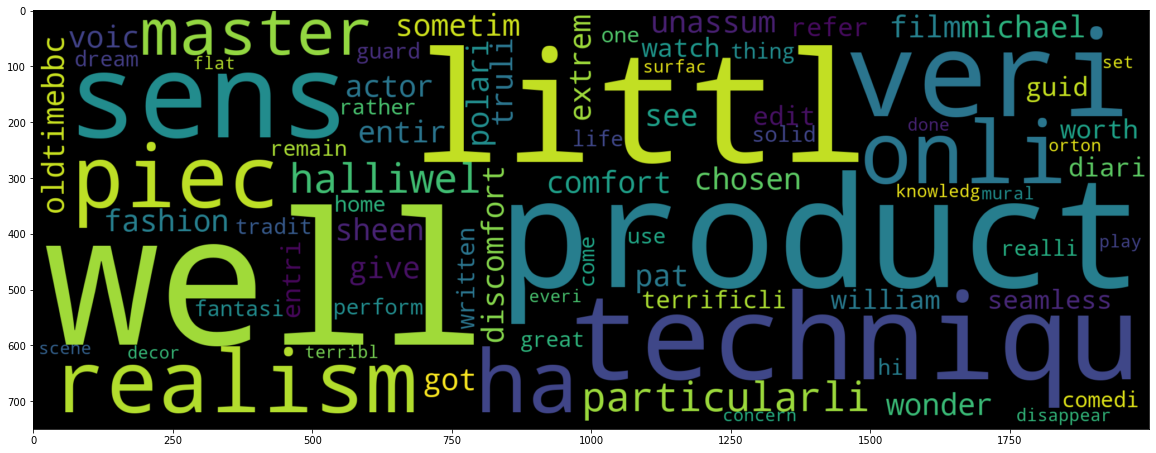

In [30]:
# example of word cloud for positive review words
pos_review_words = []
plt.figure(figsize=(20,20))
pos_text = norm_X_train[1]
wc = WordCloud(width=2000, height=750, max_words=200, min_font_size=10)
pos_words = wc.generate(pos_text)
plt.imshow(pos_words, interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

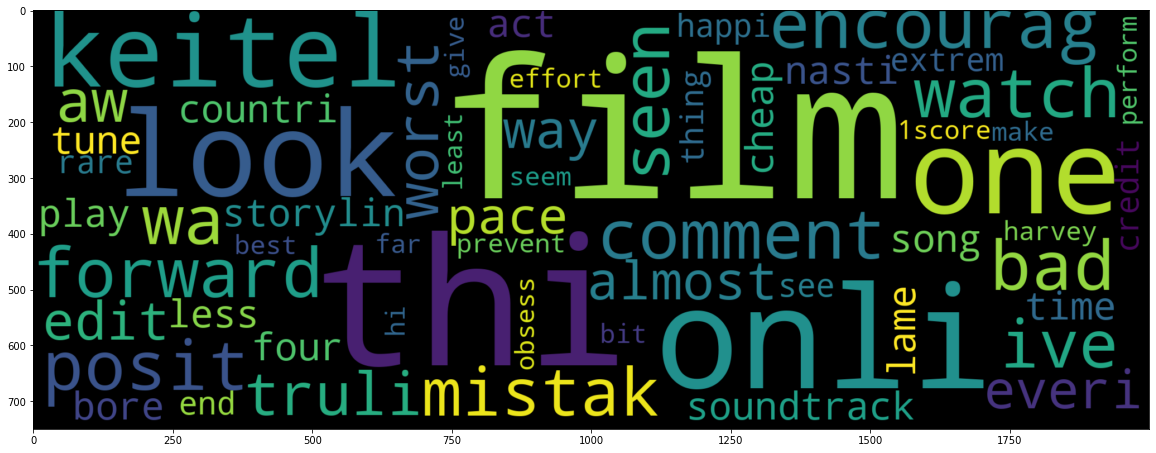

In [31]:
# example of Word cloud for negative review words
plt.figure(figsize=(20,20))
neg_text = norm_X_train[8]
wc = WordCloud(width=2000, height=750, max_words=200, min_font_size=10)
neg_words = wc.generate(neg_text)
plt.imshow(neg_words, interpolation='bilinear')
plt.show

It has to be noted that these are only examples, and it is very hard to track or understand which words are percieved as positive and negative unless we dive very deep into the code. While it is not a black box algorithm, it will take a notable amount of time and resources to uncover the entire mechanism of this algorithm, making it almost not interpretable and decreasing its explainability.